In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

import networks
from utils import load_data_mnist as load_data
from utils import accuracy, train


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Initialize network and data

In [2]:
trainloader, testloader, _ = load_data(128)

net = networks.MnistNet()

100.1%

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [3]:
train_epochs = 1

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
train(net, train_epochs, trainloader, criterion, optimizer)

accuracy(net, testloader)

Finished Training in 27 seconds
Accuracy: 0.977200


0.9772

In [4]:
data = np.load("test_images.npy")

# reshape for pytorch usage
data = torch.FloatTensor(data.transpose(0,3,1,2))

# Initialize Patternnet

In [5]:
# get list of layers in net
patternnet = networks.PatternNet(net.layers)

In [6]:
# compute statistics 
patternnet.compute_statistics(data)

# compute and set patterns
patternnet.compute_patterns()
patternnet.set_patterns()

# Compute and plot signal

In [7]:
def normalize_img(img):
    img_n = img - img.min()
    img_n = img_n / img_n.max()
    
    return img_n

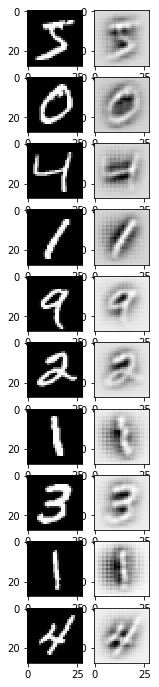

In [8]:
signals = patternnet(data[:10])

plt.figure(figsize=(7,12))
for i in range(10):
    plt.subplot(10,6,i*6+2)
    plt.imshow(normalize_img(signals.data[i,0]), cmap='gray')
    plt.subplot(10,6,i*6+1)
    plt.imshow(normalize_img(data[i,0]), cmap='gray')
    

plt.show()